## Preprocessing marker identification training datasets for Inception-V3

First lets load all of the python packages that we will need.

In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import skimage as sk
from skimage import morphology as morph
import scipy as sp
from scipy import ndimage
from skimage import feature
from skimage import exposure, io
from skimage.io import imread, imsave
from utils import get_image
import glob, os, fnmatch

We define the directories where the images and classes are located. We define both training and validation datasets.

In [6]:
# E2F3A
direc_name = './trainingData/markerIdentification/wholeNuclei/Confocal/E2F3A/'
file_name_save = os.path.join('./trainingDataNpz/markerIdentification/Confocal/', 'nucleiMarkers_E2F3A')
training_direcs = ["E2F3A_E2F8_mouse1_image1","E2F3A_E2F8_mouse1_image2","E2F3A_E2F8_mouse1_image3","E2F3A_EdU_mouse1_image1","E2F3A_EdU_mouse1_image2","E2F3A_EdU_mouse1_image4","E2F3A_pH3_mouse1_image1","E2F3A_pH3_mouse1_image2"] 

channel_names = ["marker"]
nb_classes = 2

We define the parameteres for preprocessing.

In [7]:
# half window size for imaging field
window_size_x = 32
window_size_y = 32
# maximum number of training cases
max_training_examples = 10000000

We load the images and initialize the variables.

In [9]:
nb_direcs = len(training_direcs)
nb_channels = len(channel_names)

# variables for images
imglist = []
for direc in training_direcs:
    imglist += os.listdir(os.path.join(direc_name, direc))

# Load one file to get image sizes
img_temp = get_image(os.path.join(direc_name,training_direcs[0],imglist[0]))
image_size_x, image_size_y = img_temp.shape

# Initialize arrays for the training images and the classes
channels = np.zeros((nb_direcs, image_size_x, image_size_y, nb_channels), dtype='float32')
class_mask = np.zeros((nb_direcs, image_size_x, image_size_y, nb_classes), dtype='float32')

We preprocess the images and classes by applyging a local average subtraction<br>


In [5]:
# Load training images
direc_counter = 0
for direc in training_direcs:
    imglist = os.listdir(os.path.join(direc_name, direc))
    channel_counter = 0

    # Load channels
    for channel in channel_names:
        for img in imglist: 
            if fnmatch.fnmatch(img, r'*' + channel + r'*'):
                channel_file = img
                channel_file = os.path.join(direc_name, direc, channel_file)
                channel_img = get_image(channel_file)
    
                # Normalize the images
                avg_kernel = np.ones((2*window_size_x + 1, 2*window_size_y + 1))
                channel_img -= ndimage.convolve(channel_img, avg_kernel)/avg_kernel.size

                channels[direc_counter,:,:,channel_counter] = channel_img
                channel_counter += 1

    # Load class mask
    for j in range(nb_classes):
        class_name = "feature_" + str(j) + r".*"
        for img in imglist:
            if fnmatch.fnmatch(img, class_name):
                class_file = os.path.join(direc_name, direc, img)
                class_img = get_image(class_file)

                if np.sum(class_img) > 0:
                    class_img /= np.amax(class_img)

                class_mask[direc_counter,:,:,j] = class_img
       
    direc_counter += 1

We plot the first 3 images and classes to make sure everything went well.

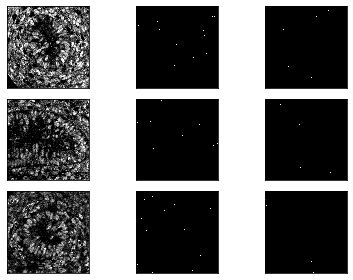

In [6]:
fig,ax = plt.subplots(3,nb_classes+1, squeeze = False)#plt.subplots(len(training_direcs),nb_classes+1, squeeze = False)
for j in range(3):#len(training_direcs)):
    ax[j,0].imshow(channels[j,:,:,0],cmap=plt.cm.gray,interpolation='nearest')
    def form_coord(x,y):
        return cf(x,y,channels[j,:,:,0])
    ax[j,0].format_coord = form_coord
    ax[j,0].axes.get_xaxis().set_visible(False)
    ax[j,0].axes.get_yaxis().set_visible(False)

    for k in range(1,nb_classes+1):
        ax[j,k].imshow(class_mask[j,:,:,k-1],cmap=plt.cm.gray,interpolation='nearest')
        def form_coord(x,y):
            return cf(x,y,class_mask[j,:,:,k-1])
        ax[j,k].format_coord = form_coord
        ax[j,k].axes.get_xaxis().set_visible(False)
        ax[j,k].axes.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()

We want to equally sample each individual class by considering for each image the minimum number of pixels corresponding to one class as the number of training examples. We estimate that number for each image.

In [7]:
class_mask_trimmed = class_mask[:,window_size_x+1:-window_size_x-1,window_size_y+1:-window_size_y-1,:] 

class_rows = []
class_cols = []
class_batch = []
class_label = []

min_pixel_counter = np.zeros((nb_direcs))
for j in range(class_mask_trimmed.shape[0]):
    min_pixel_counter[j] = np.Inf
    nb_pixels_class = 0
    for k in range(nb_classes):
        nb_pixels_class = np.sum(class_mask_trimmed[j,:,:,k])
        if nb_pixels_class < min_pixel_counter[j]:
            min_pixel_counter[j] = nb_pixels_class

We equally sample each individual class for each image.

In [8]:
for direc in range(channels.shape[0]):

    for k in range(nb_classes):
        class_counter = 0
        class_rows_temp, class_cols_temp = np.where(class_mask[direc,:,:,k] == 1)

        if len(class_rows_temp) > 0:

            # Randomly permute index vector
            non_rand_ind = np.arange(len(class_rows_temp))
            rand_ind = np.random.choice(non_rand_ind, size = len(class_rows_temp), replace = False)

            for i in rand_ind:
                if class_counter < min_pixel_counter[direc]:
                    if (class_rows_temp[i] - window_size_x > 0) and (class_rows_temp[i] + window_size_x < image_size_x): 
                        if (class_cols_temp[i] - window_size_y > 0) and (class_cols_temp[i] + window_size_y < image_size_y):
                            class_rows += [class_rows_temp[i]]
                            class_cols += [class_cols_temp[i]]
                            class_batch += [direc]
                            class_label += [k]
                            class_counter += 1

class_rows = np.array(class_rows,dtype = 'int32')
class_cols = np.array(class_cols,dtype = 'int32')
class_batch = np.array(class_batch, dtype = 'int32')
class_label = np.array(class_label, dtype = 'int32')

We randomly shuffle the order of the training examples and make sure the number of training examples is inferior to the defined cap.

In [9]:
# Randomly select training points 
if len(class_rows) > max_training_examples:
    non_rand_ind = np.arange(len(class_rows))
    rand_ind = np.random.choice(non_rand_ind, size = max_training_examples, replace = False)

    class_rows = class_rows[rand_ind]
    class_cols = class_cols[rand_ind]
    class_batch = class_batch[rand_ind]
    class_label = class_label[rand_ind]

# Randomize
non_rand_ind = np.arange(len(class_rows))
rand_ind = np.random.choice(non_rand_ind, size = len(class_rows), replace = False)

class_rows = class_rows[rand_ind]
class_cols = class_cols[rand_ind]
class_batch = class_batch[rand_ind]
class_label = class_label[rand_ind]

We save the preprocessed training dataset.

In [10]:
np.savez(file_name_save, channels = channels, y = class_label, batch = class_batch, pixels_x = class_rows, pixels_y = class_cols, win_x = window_size_x, win_y = window_size_y)

In [12]:
# E2F8
direc_name = './trainingData/markerIdentification/wholeNuclei/Confocal/E2F8/'
file_name_save = os.path.join('./trainingDataNpz/markerIdentification/Confocal/', 'nucleiMarkers_E2F8')
training_direcs = ["E2F3A_E2F8_mouse1_image1","E2F3A_E2F8_mouse1_image2","E2F3A_E2F8_mouse1_image3","E2F8_EdU_mouse1_image1","E2F8_pH3_mouse1_image2"] 
nb_classes = 2

nb_direcs = len(training_direcs)

# variables for images
imglist = []
for direc in training_direcs:
    imglist += os.listdir(os.path.join(direc_name, direc))

# Load one file to get image sizes
img_temp = get_image(os.path.join(direc_name,training_direcs[0],imglist[0]))
image_size_x, image_size_y = img_temp.shape

# Initialize arrays for the training images and the classes
channels = np.zeros((nb_direcs, image_size_x, image_size_y, nb_channels), dtype='float32')
class_mask = np.zeros((nb_direcs, image_size_x, image_size_y, nb_classes), dtype='float32')

# Load training images
direc_counter = 0
for direc in training_direcs:
    imglist = os.listdir(os.path.join(direc_name, direc))
    channel_counter = 0

    # Load channels
    for channel in channel_names:
        for img in imglist: 
            if fnmatch.fnmatch(img, r'*' + channel + r'*'):
                channel_file = img
                channel_file = os.path.join(direc_name, direc, channel_file)
                channel_img = get_image(channel_file)
    
                # Normalize the images
                avg_kernel = np.ones((2*window_size_x + 1, 2*window_size_y + 1))
                channel_img -= ndimage.convolve(channel_img, avg_kernel)/avg_kernel.size

                channels[direc_counter,:,:,channel_counter] = channel_img
                channel_counter += 1

    # Load class mask
    for j in range(nb_classes):
        class_name = "feature_" + str(j) + r".*"
        for img in imglist:
            if fnmatch.fnmatch(img, class_name):
                class_file = os.path.join(direc_name, direc, img)
                class_img = get_image(class_file)

                if np.sum(class_img) > 0:
                    class_img /= np.amax(class_img)

                class_mask[direc_counter,:,:,j] = class_img
       
    direc_counter += 1

# equal sampling
class_mask_trimmed = class_mask[:,window_size_x+1:-window_size_x-1,window_size_y+1:-window_size_y-1,:] 

class_rows = []
class_cols = []
class_batch = []
class_label = []

min_pixel_counter = np.zeros((nb_direcs))
for j in range(class_mask_trimmed.shape[0]):
    min_pixel_counter[j] = np.Inf
    nb_pixels_class = 0
    for k in range(nb_classes):
        nb_pixels_class = np.sum(class_mask_trimmed[j,:,:,k])
        if nb_pixels_class < min_pixel_counter[j]:
            min_pixel_counter[j] = nb_pixels_class

for direc in range(channels.shape[0]):

    for k in range(nb_classes):
        class_counter = 0
        class_rows_temp, class_cols_temp = np.where(class_mask[direc,:,:,k] == 1)

        if len(class_rows_temp) > 0:

            # Randomly permute index vector
            non_rand_ind = np.arange(len(class_rows_temp))
            rand_ind = np.random.choice(non_rand_ind, size = len(class_rows_temp), replace = False)

            for i in rand_ind:
                if class_counter < min_pixel_counter[direc]:
                    if (class_rows_temp[i] - window_size_x > 0) and (class_rows_temp[i] + window_size_x < image_size_x): 
                        if (class_cols_temp[i] - window_size_y > 0) and (class_cols_temp[i] + window_size_y < image_size_y):
                            class_rows += [class_rows_temp[i]]
                            class_cols += [class_cols_temp[i]]
                            class_batch += [direc]
                            class_label += [k]
                            class_counter += 1

class_rows = np.array(class_rows,dtype = 'int32')
class_cols = np.array(class_cols,dtype = 'int32')
class_batch = np.array(class_batch, dtype = 'int32')
class_label = np.array(class_label, dtype = 'int32')

# Randomly select training points 
if len(class_rows) > max_training_examples:
    non_rand_ind = np.arange(len(class_rows))
    rand_ind = np.random.choice(non_rand_ind, size = max_training_examples, replace = False)

    class_rows = class_rows[rand_ind]
    class_cols = class_cols[rand_ind]
    class_batch = class_batch[rand_ind]
    class_label = class_label[rand_ind]

# Randomize
non_rand_ind = np.arange(len(class_rows))
rand_ind = np.random.choice(non_rand_ind, size = len(class_rows), replace = False)

class_rows = class_rows[rand_ind]
class_cols = class_cols[rand_ind]
class_batch = class_batch[rand_ind]
class_label = class_label[rand_ind]

# save
np.savez(file_name_save, channels = channels, y = class_label, batch = class_batch, pixels_x = class_rows, pixels_y = class_cols, win_x = window_size_x, win_y = window_size_y)

In [13]:
# EdU
direc_name = './trainingData/markerIdentification/wholeNuclei/Confocal/EdU/'
file_name_save = os.path.join('./trainingDataNpz/markerIdentification/Confocal/', 'nucleiMarkers_EdU')
training_direcs = ["E2F3A_EdU_mouse1_image1","E2F3A_EdU_mouse1_image2","E2F3A_EdU_mouse1_image4","E2F8_EdU_mouse1_image1"] 
channel_names = ["marker"]
nb_classes = 3

nb_direcs = len(training_direcs)

# variables for images
imglist = []
for direc in training_direcs:
    imglist += os.listdir(os.path.join(direc_name, direc))

# Load one file to get image sizes
img_temp = get_image(os.path.join(direc_name,training_direcs[0],imglist[0]))
image_size_x, image_size_y = img_temp.shape

# Initialize arrays for the training images and the classes
channels = np.zeros((nb_direcs, image_size_x, image_size_y, nb_channels), dtype='float32')
class_mask = np.zeros((nb_direcs, image_size_x, image_size_y, nb_classes), dtype='float32')

# Load training images
direc_counter = 0
for direc in training_direcs:
    imglist = os.listdir(os.path.join(direc_name, direc))
    channel_counter = 0

    # Load channels
    for channel in channel_names:
        for img in imglist: 
            if fnmatch.fnmatch(img, r'*' + channel + r'*'):
                channel_file = img
                channel_file = os.path.join(direc_name, direc, channel_file)
                channel_img = get_image(channel_file)
    
                # Normalize the images
                avg_kernel = np.ones((2*window_size_x + 1, 2*window_size_y + 1))
                channel_img -= ndimage.convolve(channel_img, avg_kernel)/avg_kernel.size

                channels[direc_counter,:,:,channel_counter] = channel_img
                channel_counter += 1

    # Load class mask
    for j in range(nb_classes):
        class_name = "feature_" + str(j) + r".*"
        for img in imglist:
            if fnmatch.fnmatch(img, class_name):
                class_file = os.path.join(direc_name, direc, img)
                class_img = get_image(class_file)

                if np.sum(class_img) > 0:
                    class_img /= np.amax(class_img)

                class_mask[direc_counter,:,:,j] = class_img
       
    direc_counter += 1
    
# equal sampling
class_mask_trimmed = class_mask[:,window_size_x+1:-window_size_x-1,window_size_y+1:-window_size_y-1,:] 

class_rows = []
class_cols = []
class_batch = []
class_label = []

min_pixel_counter = np.zeros((nb_direcs))
for j in range(class_mask_trimmed.shape[0]):
    min_pixel_counter[j] = np.Inf
    nb_pixels_class = 0
    for k in range(nb_classes):
        nb_pixels_class = np.sum(class_mask_trimmed[j,:,:,k])
        if nb_pixels_class < min_pixel_counter[j]:
            min_pixel_counter[j] = nb_pixels_class

for direc in range(channels.shape[0]):

    for k in range(nb_classes):
        class_counter = 0
        class_rows_temp, class_cols_temp = np.where(class_mask[direc,:,:,k] == 1)

        if len(class_rows_temp) > 0:

            # Randomly permute index vector
            non_rand_ind = np.arange(len(class_rows_temp))
            rand_ind = np.random.choice(non_rand_ind, size = len(class_rows_temp), replace = False)

            for i in rand_ind:
                if class_counter < min_pixel_counter[direc]:
                    if (class_rows_temp[i] - window_size_x > 0) and (class_rows_temp[i] + window_size_x < image_size_x): 
                        if (class_cols_temp[i] - window_size_y > 0) and (class_cols_temp[i] + window_size_y < image_size_y):
                            class_rows += [class_rows_temp[i]]
                            class_cols += [class_cols_temp[i]]
                            class_batch += [direc]
                            class_label += [k]
                            class_counter += 1

class_rows = np.array(class_rows,dtype = 'int32')
class_cols = np.array(class_cols,dtype = 'int32')
class_batch = np.array(class_batch, dtype = 'int32')
class_label = np.array(class_label, dtype = 'int32')

# Randomly select training points 
if len(class_rows) > max_training_examples:
    non_rand_ind = np.arange(len(class_rows))
    rand_ind = np.random.choice(non_rand_ind, size = max_training_examples, replace = False)

    class_rows = class_rows[rand_ind]
    class_cols = class_cols[rand_ind]
    class_batch = class_batch[rand_ind]
    class_label = class_label[rand_ind]

# Randomize
non_rand_ind = np.arange(len(class_rows))
rand_ind = np.random.choice(non_rand_ind, size = len(class_rows), replace = False)

class_rows = class_rows[rand_ind]
class_cols = class_cols[rand_ind]
class_batch = class_batch[rand_ind]
class_label = class_label[rand_ind]

# save
np.savez(file_name_save, channels = channels, y = class_label, batch = class_batch, pixels_x = class_rows, pixels_y = class_cols, win_x = window_size_x, win_y = window_size_y)

In [14]:
# pH3
direc_name = './trainingData/markerIdentification/wholeNuclei/Confocal/pH3/'
file_name_save = os.path.join('./trainingDataNpz/markerIdentification/Confocal/', 'nucleiMarkers_pH3')
training_direcs = ["E2F3A_pH3_mouse1_image1","E2F3A_pH3_mouse1_image2","E2F8_pH3_mouse1_image2"] 
channel_names = ["marker"]
nb_classes = 3

nb_direcs = len(training_direcs)

# variables for images
imglist = []
for direc in training_direcs:
    imglist += os.listdir(os.path.join(direc_name, direc))

# Load one file to get image sizes
img_temp = get_image(os.path.join(direc_name,training_direcs[0],imglist[0]))
image_size_x, image_size_y = img_temp.shape

# Initialize arrays for the training images and the classes
channels = np.zeros((nb_direcs, image_size_x, image_size_y, nb_channels), dtype='float32')
class_mask = np.zeros((nb_direcs, image_size_x, image_size_y, nb_classes), dtype='float32')

# Load training images
direc_counter = 0
for direc in training_direcs:
    imglist = os.listdir(os.path.join(direc_name, direc))
    channel_counter = 0

    # Load channels
    for channel in channel_names:
        for img in imglist: 
            if fnmatch.fnmatch(img, r'*' + channel + r'*'):
                channel_file = img
                channel_file = os.path.join(direc_name, direc, channel_file)
                channel_img = get_image(channel_file)
    
                # Normalize the images
                avg_kernel = np.ones((2*window_size_x + 1, 2*window_size_y + 1))
                channel_img -= ndimage.convolve(channel_img, avg_kernel)/avg_kernel.size

                channels[direc_counter,:,:,channel_counter] = channel_img
                channel_counter += 1

    # Load class mask
    for j in range(nb_classes):
        class_name = "feature_" + str(j) + r".*"
        for img in imglist:
            if fnmatch.fnmatch(img, class_name):
                class_file = os.path.join(direc_name, direc, img)
                class_img = get_image(class_file)

                if np.sum(class_img) > 0:
                    class_img /= np.amax(class_img)

                class_mask[direc_counter,:,:,j] = class_img
       
    direc_counter += 1
    
# equal sampling
class_mask_trimmed = class_mask[:,window_size_x+1:-window_size_x-1,window_size_y+1:-window_size_y-1,:] 

class_rows = []
class_cols = []
class_batch = []
class_label = []

min_pixel_counter = np.zeros((nb_direcs))
for j in range(class_mask_trimmed.shape[0]):
    min_pixel_counter[j] = np.Inf
    nb_pixels_class = 0
    for k in range(nb_classes):
        nb_pixels_class = np.sum(class_mask_trimmed[j,:,:,k])
        if nb_pixels_class < min_pixel_counter[j]:
            min_pixel_counter[j] = nb_pixels_class

for direc in range(channels.shape[0]):

    for k in range(nb_classes):
        class_counter = 0
        class_rows_temp, class_cols_temp = np.where(class_mask[direc,:,:,k] == 1)

        if len(class_rows_temp) > 0:

            # Randomly permute index vector
            non_rand_ind = np.arange(len(class_rows_temp))
            rand_ind = np.random.choice(non_rand_ind, size = len(class_rows_temp), replace = False)

            for i in rand_ind:
                if class_counter < min_pixel_counter[direc]:
                    if (class_rows_temp[i] - window_size_x > 0) and (class_rows_temp[i] + window_size_x < image_size_x): 
                        if (class_cols_temp[i] - window_size_y > 0) and (class_cols_temp[i] + window_size_y < image_size_y):
                            class_rows += [class_rows_temp[i]]
                            class_cols += [class_cols_temp[i]]
                            class_batch += [direc]
                            class_label += [k]
                            class_counter += 1

class_rows = np.array(class_rows,dtype = 'int32')
class_cols = np.array(class_cols,dtype = 'int32')
class_batch = np.array(class_batch, dtype = 'int32')
class_label = np.array(class_label, dtype = 'int32')

# Randomly select training points 
if len(class_rows) > max_training_examples:
    non_rand_ind = np.arange(len(class_rows))
    rand_ind = np.random.choice(non_rand_ind, size = max_training_examples, replace = False)

    class_rows = class_rows[rand_ind]
    class_cols = class_cols[rand_ind]
    class_batch = class_batch[rand_ind]
    class_label = class_label[rand_ind]

# Randomize
non_rand_ind = np.arange(len(class_rows))
rand_ind = np.random.choice(non_rand_ind, size = len(class_rows), replace = False)

class_rows = class_rows[rand_ind]
class_cols = class_cols[rand_ind]
class_batch = class_batch[rand_ind]
class_label = class_label[rand_ind]

# save
np.savez(file_name_save, channels = channels, y = class_label, batch = class_batch, pixels_x = class_rows, pixels_y = class_cols, win_x = window_size_x, win_y = window_size_y)

In [13]:
# wide-field
# E2F3A
direc_name = './trainingData/markerIdentification/wholeNuclei/Widefield/E2F3A/'
file_name_save = os.path.join('./trainingDataNpz/markerIdentification/Widefield/', 'nucleiMarkers_test_E2F3A')
training_direcs = ["E2F3A_E2F4_mouse1_image1","E2F3A_E2F4_mouse1_image2","E2F3A_E2F4_mouse2_image1","E2F3A_E2F4_mouse2_image2","E2F3A_E2F4_mouse2_image3","E2F3A_E2F8_mouse2_image1","E2F3A_E2F8_mouse2_image2","E2F3A_E2F8_mouse3_image1","E2F3A_E2F8_mouse3_image2","E2F3A_E2F8_mouse3_image3","E2F3A_EdU_mouse2_image1","E2F3A_EdU_mouse2_image2","E2F3A_EdU_mouse2_image3","E2F3A_EdU_mouse3_image1","E2F3A_EdU_mouse3_image2","E2F3A_pH3_mouse2_image1","E2F3A_pH3_mouse2_image2","E2F3A_pH3_mouse2_image3","E2F3A_pH3_mouse3_image1","E2F3A_pH3_mouse3_image2","E2F3A_pH3_mouse3_image3"] 
channel_names = ["marker"]
nb_classes = 2

nb_direcs = len(training_direcs)

# variables for images
imglist = []
for direc in training_direcs:
    imglist += os.listdir(os.path.join(direc_name, direc))

# Load one file to get image sizes
img_temp = get_image(os.path.join(direc_name,training_direcs[0],imglist[0]))
image_size_x, image_size_y = img_temp.shape

# Initialize arrays for the training images and the classes
channels = np.zeros((nb_direcs, image_size_x, image_size_y, nb_channels), dtype='float32')
class_mask = np.zeros((nb_direcs, image_size_x, image_size_y, nb_classes), dtype='float32')

# Load training images
direc_counter = 0
for direc in training_direcs:
    imglist = os.listdir(os.path.join(direc_name, direc))
    channel_counter = 0

    # Load channels
    for channel in channel_names:
        for img in imglist: 
            if fnmatch.fnmatch(img, r'*' + channel + r'*'):
                channel_file = img
                channel_file = os.path.join(direc_name, direc, channel_file)
                channel_img = get_image(channel_file)
    
                # Normalize the images
                avg_kernel = np.ones((2*window_size_x + 1, 2*window_size_y + 1))
                channel_img -= ndimage.convolve(channel_img, avg_kernel)/avg_kernel.size

                channels[direc_counter,:,:,channel_counter] = channel_img
                channel_counter += 1

    # Load class mask
    for j in range(nb_classes):
        class_name = "feature_" + str(j) + r".*"
        for img in imglist:
            if fnmatch.fnmatch(img, class_name):
                class_file = os.path.join(direc_name, direc, img)
                class_img = get_image(class_file)

                if np.sum(class_img) > 0:
                    class_img /= np.amax(class_img)

                class_mask[direc_counter,:,:,j] = class_img
       
    direc_counter += 1
    
# equal sampling
class_mask_trimmed = class_mask[:,window_size_x+1:-window_size_x-1,window_size_y+1:-window_size_y-1,:] 

class_rows = []
class_cols = []
class_batch = []
class_label = []

min_pixel_counter = np.zeros((nb_direcs))
for j in range(class_mask_trimmed.shape[0]):
    min_pixel_counter[j] = np.Inf
    nb_pixels_class = 0
    for k in range(nb_classes):
        nb_pixels_class = np.sum(class_mask_trimmed[j,:,:,k])
        if nb_pixels_class < min_pixel_counter[j]:
            min_pixel_counter[j] = nb_pixels_class

for direc in range(channels.shape[0]):

    for k in range(nb_classes):
        class_counter = 0
        class_rows_temp, class_cols_temp = np.where(class_mask[direc,:,:,k] == 1)

        if len(class_rows_temp) > 0:

            # Randomly permute index vector
            non_rand_ind = np.arange(len(class_rows_temp))
            rand_ind = np.random.choice(non_rand_ind, size = len(class_rows_temp), replace = False)

            for i in rand_ind:
                if class_counter < min_pixel_counter[direc]:
                    if (class_rows_temp[i] - window_size_x > 0) and (class_rows_temp[i] + window_size_x < image_size_x): 
                        if (class_cols_temp[i] - window_size_y > 0) and (class_cols_temp[i] + window_size_y < image_size_y):
                            class_rows += [class_rows_temp[i]]
                            class_cols += [class_cols_temp[i]]
                            class_batch += [direc]
                            class_label += [k]
                            class_counter += 1

class_rows = np.array(class_rows,dtype = 'int32')
class_cols = np.array(class_cols,dtype = 'int32')
class_batch = np.array(class_batch, dtype = 'int32')
class_label = np.array(class_label, dtype = 'int32')

# Randomly select training points 
if len(class_rows) > max_training_examples:
    non_rand_ind = np.arange(len(class_rows))
    rand_ind = np.random.choice(non_rand_ind, size = max_training_examples, replace = False)

    class_rows = class_rows[rand_ind]
    class_cols = class_cols[rand_ind]
    class_batch = class_batch[rand_ind]
    class_label = class_label[rand_ind]

# Randomize
non_rand_ind = np.arange(len(class_rows))
rand_ind = np.random.choice(non_rand_ind, size = len(class_rows), replace = False)

class_rows = class_rows[rand_ind]
class_cols = class_cols[rand_ind]
class_batch = class_batch[rand_ind]
class_label = class_label[rand_ind]

# save
np.savez(file_name_save, channels = channels, y = class_label, batch = class_batch, pixels_x = class_rows, pixels_y = class_cols, win_x = window_size_x, win_y = window_size_y)

In [16]:
# E2F8
direc_name = './trainingData/markerIdentification/wholeNuclei/Widefield/E2F8/'
file_name_save = os.path.join('./trainingDataNpz/markerIdentification/Widefield/', 'nucleiMarkers_E2F8')
training_direcs = ["E2F3A_E2F8_mouse2_image1","E2F3A_E2F8_mouse2_image2","E2F3A_E2F8_mouse3_image1","E2F3A_E2F8_mouse3_image2","E2F3A_E2F8_mouse3_image3","E2F8_EdU_mouse2_image1","E2F8_EdU_mouse2_image2","E2F8_EdU_mouse3_image1","E2F8_EdU_mouse3_image2","E2F8_EdU_mouse3_image3","E2F8_pH3_mouse2_image1","E2F8_pH3_mouse2_image2","E2F8_pH3_mouse2_image3","E2F8_pH3_mouse3_image1","E2F8_pH3_mouse3_image2"] 
channel_names = ["marker"]
nb_classes = 2

nb_direcs = len(training_direcs)

# variables for images
imglist = []
for direc in training_direcs:
    imglist += os.listdir(os.path.join(direc_name, direc))

# Load one file to get image sizes
img_temp = get_image(os.path.join(direc_name,training_direcs[0],imglist[0]))
image_size_x, image_size_y = img_temp.shape

# Initialize arrays for the training images and the classes
channels = np.zeros((nb_direcs, image_size_x, image_size_y, nb_channels), dtype='float32')
class_mask = np.zeros((nb_direcs, image_size_x, image_size_y, nb_classes), dtype='float32')

# Load training images
direc_counter = 0
for direc in training_direcs:
    imglist = os.listdir(os.path.join(direc_name, direc))
    channel_counter = 0

    # Load channels
    for channel in channel_names:
        for img in imglist: 
            if fnmatch.fnmatch(img, r'*' + channel + r'*'):
                channel_file = img
                channel_file = os.path.join(direc_name, direc, channel_file)
                channel_img = get_image(channel_file)
    
                # Normalize the images
                avg_kernel = np.ones((2*window_size_x + 1, 2*window_size_y + 1))
                channel_img -= ndimage.convolve(channel_img, avg_kernel)/avg_kernel.size

                channels[direc_counter,:,:,channel_counter] = channel_img
                channel_counter += 1

    # Load class mask
    for j in range(nb_classes):
        class_name = "feature_" + str(j) + r".*"
        for img in imglist:
            if fnmatch.fnmatch(img, class_name):
                class_file = os.path.join(direc_name, direc, img)
                class_img = get_image(class_file)

                if np.sum(class_img) > 0:
                    class_img /= np.amax(class_img)

                class_mask[direc_counter,:,:,j] = class_img
       
    direc_counter += 1
    
# equal sampling
class_mask_trimmed = class_mask[:,window_size_x+1:-window_size_x-1,window_size_y+1:-window_size_y-1,:] 

class_rows = []
class_cols = []
class_batch = []
class_label = []

min_pixel_counter = np.zeros((nb_direcs))
for j in range(class_mask_trimmed.shape[0]):
    min_pixel_counter[j] = np.Inf
    nb_pixels_class = 0
    for k in range(nb_classes):
        nb_pixels_class = np.sum(class_mask_trimmed[j,:,:,k])
        if nb_pixels_class < min_pixel_counter[j]:
            min_pixel_counter[j] = nb_pixels_class

for direc in range(channels.shape[0]):

    for k in range(nb_classes):
        class_counter = 0
        class_rows_temp, class_cols_temp = np.where(class_mask[direc,:,:,k] == 1)

        if len(class_rows_temp) > 0:

            # Randomly permute index vector
            non_rand_ind = np.arange(len(class_rows_temp))
            rand_ind = np.random.choice(non_rand_ind, size = len(class_rows_temp), replace = False)

            for i in rand_ind:
                if class_counter < min_pixel_counter[direc]:
                    if (class_rows_temp[i] - window_size_x > 0) and (class_rows_temp[i] + window_size_x < image_size_x): 
                        if (class_cols_temp[i] - window_size_y > 0) and (class_cols_temp[i] + window_size_y < image_size_y):
                            class_rows += [class_rows_temp[i]]
                            class_cols += [class_cols_temp[i]]
                            class_batch += [direc]
                            class_label += [k]
                            class_counter += 1

class_rows = np.array(class_rows,dtype = 'int32')
class_cols = np.array(class_cols,dtype = 'int32')
class_batch = np.array(class_batch, dtype = 'int32')
class_label = np.array(class_label, dtype = 'int32')

# Randomly select training points 
if len(class_rows) > max_training_examples:
    non_rand_ind = np.arange(len(class_rows))
    rand_ind = np.random.choice(non_rand_ind, size = max_training_examples, replace = False)

    class_rows = class_rows[rand_ind]
    class_cols = class_cols[rand_ind]
    class_batch = class_batch[rand_ind]
    class_label = class_label[rand_ind]

# Randomize
non_rand_ind = np.arange(len(class_rows))
rand_ind = np.random.choice(non_rand_ind, size = len(class_rows), replace = False)

class_rows = class_rows[rand_ind]
class_cols = class_cols[rand_ind]
class_batch = class_batch[rand_ind]
class_label = class_label[rand_ind]

# save
np.savez(file_name_save, channels = channels, y = class_label, batch = class_batch, pixels_x = class_rows, pixels_y = class_cols, win_x = window_size_x, win_y = window_size_y)

In [11]:
# E2F4
direc_name = './trainingData/markerIdentification/wholeNuclei/Widefield/E2F4/'
file_name_save = os.path.join('./trainingDataNpz/markerIdentification/Widefield/', 'nucleiMarkers_E2F4')
training_direcs = ["E2F3A_E2F4_mouse1_image1","E2F3A_E2F4_mouse1_image2","E2F3A_E2F4_mouse2_image1","E2F3A_E2F4_mouse2_image2","E2F3A_E2F4_mouse2_image3","E2F4_EdU_mouse1_image1","E2F4_EdU_mouse1_image2","E2F4_EdU_mouse1_image3","E2F4_EdU_mouse2_image1","E2F4_EdU_mouse2_image2","E2F4_pH3_mouse1_image1","E2F4_pH3_mouse1_image2","E2F4_pH3_mouse2_image1","E2F4_pH3_mouse2_image2","E2F4_pH3_mouse2_image3"]
channel_names = ["marker"]
nb_classes = 2

nb_direcs = len(training_direcs)

# variables for images
imglist = []
for direc in training_direcs:
    imglist += os.listdir(os.path.join(direc_name, direc))

# Load one file to get image sizes
img_temp = get_image(os.path.join(direc_name,training_direcs[0],imglist[0]))
image_size_x, image_size_y = img_temp.shape

# Initialize arrays for the training images and the classes
channels = np.zeros((nb_direcs, image_size_x, image_size_y, nb_channels), dtype='float32')
class_mask = np.zeros((nb_direcs, image_size_x, image_size_y, nb_classes), dtype='float32')

# Load training images
direc_counter = 0
for direc in training_direcs:
    imglist = os.listdir(os.path.join(direc_name, direc))
    channel_counter = 0

    # Load channels
    for channel in channel_names:
        for img in imglist: 
            if fnmatch.fnmatch(img, r'*' + channel + r'*'):
                channel_file = img
                channel_file = os.path.join(direc_name, direc, channel_file)
                channel_img = get_image(channel_file)
    
                # Normalize the images
                avg_kernel = np.ones((2*window_size_x + 1, 2*window_size_y + 1))
                channel_img -= ndimage.convolve(channel_img, avg_kernel)/avg_kernel.size

                channels[direc_counter,:,:,channel_counter] = channel_img
                channel_counter += 1

    # Load class mask
    for j in range(nb_classes):
        class_name = "feature_" + str(j) + r".*"
        for img in imglist:
            if fnmatch.fnmatch(img, class_name):
                class_file = os.path.join(direc_name, direc, img)
                class_img = get_image(class_file)

                if np.sum(class_img) > 0:
                    class_img /= np.amax(class_img)

                class_mask[direc_counter,:,:,j] = class_img
       
    direc_counter += 1
    
# equal sampling
class_mask_trimmed = class_mask[:,window_size_x+1:-window_size_x-1,window_size_y+1:-window_size_y-1,:] 

class_rows = []
class_cols = []
class_batch = []
class_label = []

min_pixel_counter = np.zeros((nb_direcs))
for j in range(class_mask_trimmed.shape[0]):
    min_pixel_counter[j] = np.Inf
    nb_pixels_class = 0
    for k in range(nb_classes):
        nb_pixels_class = np.sum(class_mask_trimmed[j,:,:,k])
        if nb_pixels_class < min_pixel_counter[j]:
            min_pixel_counter[j] = nb_pixels_class

for direc in range(channels.shape[0]):

    for k in range(nb_classes):
        class_counter = 0
        class_rows_temp, class_cols_temp = np.where(class_mask[direc,:,:,k] == 1)

        if len(class_rows_temp) > 0:

            # Randomly permute index vector
            non_rand_ind = np.arange(len(class_rows_temp))
            rand_ind = np.random.choice(non_rand_ind, size = len(class_rows_temp), replace = False)

            for i in rand_ind:
                if class_counter < min_pixel_counter[direc]:
                    if (class_rows_temp[i] - window_size_x > 0) and (class_rows_temp[i] + window_size_x < image_size_x): 
                        if (class_cols_temp[i] - window_size_y > 0) and (class_cols_temp[i] + window_size_y < image_size_y):
                            class_rows += [class_rows_temp[i]]
                            class_cols += [class_cols_temp[i]]
                            class_batch += [direc]
                            class_label += [k]
                            class_counter += 1

class_rows = np.array(class_rows,dtype = 'int32')
class_cols = np.array(class_cols,dtype = 'int32')
class_batch = np.array(class_batch, dtype = 'int32')
class_label = np.array(class_label, dtype = 'int32')

# Randomly select training points 
if len(class_rows) > max_training_examples:
    non_rand_ind = np.arange(len(class_rows))
    rand_ind = np.random.choice(non_rand_ind, size = max_training_examples, replace = False)

    class_rows = class_rows[rand_ind]
    class_cols = class_cols[rand_ind]
    class_batch = class_batch[rand_ind]
    class_label = class_label[rand_ind]

# Randomize
non_rand_ind = np.arange(len(class_rows))
rand_ind = np.random.choice(non_rand_ind, size = len(class_rows), replace = False)

class_rows = class_rows[rand_ind]
class_cols = class_cols[rand_ind]
class_batch = class_batch[rand_ind]
class_label = class_label[rand_ind]

# save
np.savez(file_name_save, channels = channels, y = class_label, batch = class_batch, pixels_x = class_rows, pixels_y = class_cols, win_x = window_size_x, win_y = window_size_y)

In [18]:
# EdU
direc_name = './trainingData/markerIdentification/wholeNuclei/Widefield/EdU/'
file_name_save = os.path.join('./trainingDataNpz/markerIdentification/Widefield/', 'nucleiMarkers_EdU')
training_direcs = ["E2F3A_EdU_mouse2_image1","E2F3A_EdU_mouse2_image2","E2F3A_EdU_mouse2_image3","E2F3A_EdU_mouse3_image1","E2F3A_EdU_mouse3_image2","E2F4_EdU_mouse1_image1","E2F4_EdU_mouse1_image2","E2F4_EdU_mouse1_image3","E2F4_EdU_mouse2_image1","E2F4_EdU_mouse2_image2","E2F8_EdU_mouse2_image1","E2F8_EdU_mouse2_image2","E2F8_EdU_mouse3_image1","E2F8_EdU_mouse3_image2","E2F8_EdU_mouse3_image3"] 
channel_names = ["marker"]
nb_classes = 3

nb_direcs = len(training_direcs)

# variables for images
imglist = []
for direc in training_direcs:
    imglist += os.listdir(os.path.join(direc_name, direc))

# Load one file to get image sizes
img_temp = get_image(os.path.join(direc_name,training_direcs[0],imglist[0]))
image_size_x, image_size_y = img_temp.shape

# Initialize arrays for the training images and the classes
channels = np.zeros((nb_direcs, image_size_x, image_size_y, nb_channels), dtype='float32')
class_mask = np.zeros((nb_direcs, image_size_x, image_size_y, nb_classes), dtype='float32')

# Load training images
direc_counter = 0
for direc in training_direcs:
    imglist = os.listdir(os.path.join(direc_name, direc))
    channel_counter = 0

    # Load channels
    for channel in channel_names:
        for img in imglist: 
            if fnmatch.fnmatch(img, r'*' + channel + r'*'):
                channel_file = img
                channel_file = os.path.join(direc_name, direc, channel_file)
                channel_img = get_image(channel_file)
    
                # Normalize the images
                avg_kernel = np.ones((2*window_size_x + 1, 2*window_size_y + 1))
                channel_img -= ndimage.convolve(channel_img, avg_kernel)/avg_kernel.size

                channels[direc_counter,:,:,channel_counter] = channel_img
                channel_counter += 1

    # Load class mask
    for j in range(nb_classes):
        class_name = "feature_" + str(j) + r".*"
        for img in imglist:
            if fnmatch.fnmatch(img, class_name):
                class_file = os.path.join(direc_name, direc, img)
                class_img = get_image(class_file)

                if np.sum(class_img) > 0:
                    class_img /= np.amax(class_img)

                class_mask[direc_counter,:,:,j] = class_img
       
    direc_counter += 1
    
# equal sampling
class_mask_trimmed = class_mask[:,window_size_x+1:-window_size_x-1,window_size_y+1:-window_size_y-1,:] 

class_rows = []
class_cols = []
class_batch = []
class_label = []

min_pixel_counter = np.zeros((nb_direcs))
for j in range(class_mask_trimmed.shape[0]):
    min_pixel_counter[j] = np.Inf
    nb_pixels_class = 0
    for k in range(nb_classes):
        nb_pixels_class = np.sum(class_mask_trimmed[j,:,:,k])
        if nb_pixels_class < min_pixel_counter[j]:
            min_pixel_counter[j] = nb_pixels_class

for direc in range(channels.shape[0]):

    for k in range(nb_classes):
        class_counter = 0
        class_rows_temp, class_cols_temp = np.where(class_mask[direc,:,:,k] == 1)

        if len(class_rows_temp) > 0:

            # Randomly permute index vector
            non_rand_ind = np.arange(len(class_rows_temp))
            rand_ind = np.random.choice(non_rand_ind, size = len(class_rows_temp), replace = False)

            for i in rand_ind:
                if class_counter < min_pixel_counter[direc]:
                    if (class_rows_temp[i] - window_size_x > 0) and (class_rows_temp[i] + window_size_x < image_size_x): 
                        if (class_cols_temp[i] - window_size_y > 0) and (class_cols_temp[i] + window_size_y < image_size_y):
                            class_rows += [class_rows_temp[i]]
                            class_cols += [class_cols_temp[i]]
                            class_batch += [direc]
                            class_label += [k]
                            class_counter += 1

class_rows = np.array(class_rows,dtype = 'int32')
class_cols = np.array(class_cols,dtype = 'int32')
class_batch = np.array(class_batch, dtype = 'int32')
class_label = np.array(class_label, dtype = 'int32')

# Randomly select training points 
if len(class_rows) > max_training_examples:
    non_rand_ind = np.arange(len(class_rows))
    rand_ind = np.random.choice(non_rand_ind, size = max_training_examples, replace = False)

    class_rows = class_rows[rand_ind]
    class_cols = class_cols[rand_ind]
    class_batch = class_batch[rand_ind]
    class_label = class_label[rand_ind]

# Randomize
non_rand_ind = np.arange(len(class_rows))
rand_ind = np.random.choice(non_rand_ind, size = len(class_rows), replace = False)

class_rows = class_rows[rand_ind]
class_cols = class_cols[rand_ind]
class_batch = class_batch[rand_ind]
class_label = class_label[rand_ind]

# save
np.savez(file_name_save, channels = channels, y = class_label, batch = class_batch, pixels_x = class_rows, pixels_y = class_cols, win_x = window_size_x, win_y = window_size_y)

In [19]:
# pH3
direc_name = './trainingData/markerIdentification/wholeNuclei/Widefield/pH3/'
file_name_save = os.path.join('./trainingDataNpz/markerIdentification/Widefield/', 'nucleiMarkers_pH3')
training_direcs = ["E2F3A_pH3_mouse2_image1","E2F3A_pH3_mouse2_image2","E2F3A_pH3_mouse3_image1","E2F3A_pH3_mouse3_image2","E2F3A_pH3_mouse3_image3","E2F4_pH3_mouse1_image1","E2F4_pH3_mouse1_image2","E2F4_pH3_mouse2_image1","E2F4_pH3_mouse2_image2","E2F4_pH3_mouse2_image3","E2F8_pH3_mouse2_image1","E2F8_pH3_mouse2_image2","E2F8_pH3_mouse2_image3","E2F8_pH3_mouse3_image1","E2F8_pH3_mouse3_image2"]
channel_names = ["marker"]
nb_classes = 3

nb_direcs = len(training_direcs)

# variables for images
imglist = []
for direc in training_direcs:
    imglist += os.listdir(os.path.join(direc_name, direc))

# Load one file to get image sizes
img_temp = get_image(os.path.join(direc_name,training_direcs[0],imglist[0]))
image_size_x, image_size_y = img_temp.shape

# Initialize arrays for the training images and the classes
channels = np.zeros((nb_direcs, image_size_x, image_size_y, nb_channels), dtype='float32')
class_mask = np.zeros((nb_direcs, image_size_x, image_size_y, nb_classes), dtype='float32')

# Load training images
direc_counter = 0
for direc in training_direcs:
    imglist = os.listdir(os.path.join(direc_name, direc))
    channel_counter = 0

    # Load channels
    for channel in channel_names:
        for img in imglist: 
            if fnmatch.fnmatch(img, r'*' + channel + r'*'):
                channel_file = img
                channel_file = os.path.join(direc_name, direc, channel_file)
                channel_img = get_image(channel_file)
    
                # Normalize the images
                avg_kernel = np.ones((2*window_size_x + 1, 2*window_size_y + 1))
                channel_img -= ndimage.convolve(channel_img, avg_kernel)/avg_kernel.size

                channels[direc_counter,:,:,channel_counter] = channel_img
                channel_counter += 1

    # Load class mask
    for j in range(nb_classes):
        class_name = "feature_" + str(j) + r".*"
        for img in imglist:
            if fnmatch.fnmatch(img, class_name):
                class_file = os.path.join(direc_name, direc, img)
                class_img = get_image(class_file)

                if np.sum(class_img) > 0:
                    class_img /= np.amax(class_img)

                class_mask[direc_counter,:,:,j] = class_img
       
    direc_counter += 1
    
# equal sampling
class_mask_trimmed = class_mask[:,window_size_x+1:-window_size_x-1,window_size_y+1:-window_size_y-1,:] 

class_rows = []
class_cols = []
class_batch = []
class_label = []

min_pixel_counter = np.zeros((nb_direcs))
for j in range(class_mask_trimmed.shape[0]):
    min_pixel_counter[j] = np.Inf
    nb_pixels_class = 0
    for k in range(nb_classes):
        nb_pixels_class = np.sum(class_mask_trimmed[j,:,:,k])
        if nb_pixels_class < min_pixel_counter[j]:
            min_pixel_counter[j] = nb_pixels_class

for direc in range(channels.shape[0]):

    for k in range(nb_classes):
        class_counter = 0
        class_rows_temp, class_cols_temp = np.where(class_mask[direc,:,:,k] == 1)

        if len(class_rows_temp) > 0:

            # Randomly permute index vector
            non_rand_ind = np.arange(len(class_rows_temp))
            rand_ind = np.random.choice(non_rand_ind, size = len(class_rows_temp), replace = False)

            for i in rand_ind:
                if class_counter < min_pixel_counter[direc]:
                    if (class_rows_temp[i] - window_size_x > 0) and (class_rows_temp[i] + window_size_x < image_size_x): 
                        if (class_cols_temp[i] - window_size_y > 0) and (class_cols_temp[i] + window_size_y < image_size_y):
                            class_rows += [class_rows_temp[i]]
                            class_cols += [class_cols_temp[i]]
                            class_batch += [direc]
                            class_label += [k]
                            class_counter += 1

class_rows = np.array(class_rows,dtype = 'int32')
class_cols = np.array(class_cols,dtype = 'int32')
class_batch = np.array(class_batch, dtype = 'int32')
class_label = np.array(class_label, dtype = 'int32')

# Randomly select training points 
if len(class_rows) > max_training_examples:
    non_rand_ind = np.arange(len(class_rows))
    rand_ind = np.random.choice(non_rand_ind, size = max_training_examples, replace = False)

    class_rows = class_rows[rand_ind]
    class_cols = class_cols[rand_ind]
    class_batch = class_batch[rand_ind]
    class_label = class_label[rand_ind]

# Randomize
non_rand_ind = np.arange(len(class_rows))
rand_ind = np.random.choice(non_rand_ind, size = len(class_rows), replace = False)

class_rows = class_rows[rand_ind]
class_cols = class_cols[rand_ind]
class_batch = class_batch[rand_ind]
class_label = class_label[rand_ind]

# save
np.savez(file_name_save, channels = channels, y = class_label, batch = class_batch, pixels_x = class_rows, pixels_y = class_cols, win_x = window_size_x, win_y = window_size_y)